In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import load_model
import pickle
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')

# Load dataset with encoding 'latin'
df = pd.read_csv('PM10_1hr_TopFeatures.csv', index_col='Datetime', parse_dates=True, encoding='latin')

# Extract the last day's PM10 values before dropping the column
last_day_pm10 = df["AC Penrose PM10 1h average [µg/m³]"].tail(24)
last_day_dates = last_day_pm10.index

# Drop unwanted columns
df.drop(["AC Penrose PM10 1h average [µg/m³]", "Unnamed: 0"], axis=1, inplace=True)

# Display the first few rows of the updated dataframe
print(df.head())

# Display the extracted last day's PM10 values
print(last_day_pm10)


                     PM10_RollingMean3  PM10_RollingStd3  PM10_Lag1  \
Datetime                                                              
2024-01-01 04:00:00          16.961333          4.497877     13.517   
2024-01-01 05:00:00          13.544667          1.758663     15.317   
2024-01-01 06:00:00          16.011333          4.597988     11.800   
2024-01-01 07:00:00          15.150000          5.016108     20.917   
2024-01-01 08:00:00          16.005667          4.331095     12.733   

                     PM10_Lag2  PM10_Lag3  
Datetime                                   
2024-01-01 04:00:00     22.050     28.480  
2024-01-01 05:00:00     13.517     22.050  
2024-01-01 06:00:00     15.317     13.517  
2024-01-01 07:00:00     11.800     15.317  
2024-01-01 08:00:00     20.917     11.800  
Datetime
2024-07-01 08:00:00    13.7830
2024-07-01 09:00:00     5.5400
2024-07-01 10:00:00     9.7500
2024-07-01 11:00:00     9.0670
2024-07-01 12:00:00    13.6500
2024-07-01 13:00:00    10.9170

In [3]:
best_xgb_model = pickle.load(open("best_xgb_model2.pkl", "rb"))
best_rf_model = pickle.load(open("best_rf_model.pkl", "rb"))
best_svm_model = pickle.load(open("best_svm_model.pkl", "rb"))

custom_objects = {'mse': mean_squared_error}
gru_model = load_model("gru_model.h5", custom_objects=custom_objects)
lstm_model = load_model("lstm_model.keras", custom_objects=custom_objects)


In [4]:
def create_input_data(df, last_n_hours=24):
    last_data = df[-last_n_hours:]
    X = last_data.values
    return X

def predict_next_day(models, df):
    predictions = {}
    last_n_hours = 24
    X = create_input_data(df, last_n_hours)

    predictions['xgb'] = best_xgb_model.predict(X)
    predictions['rf'] = best_rf_model.predict(X)
    predictions['svm'] = best_svm_model.predict(X)

    X_reshaped = X.reshape((1, X.shape[0], X.shape[1]))
    predictions['gru'] = gru_model.predict(X_reshaped).flatten()
    predictions['lstm'] = lstm_model.predict(X_reshaped).flatten()

    return predictions


In [5]:
predictions = predict_next_day([best_xgb_model, best_rf_model, best_svm_model, gru_model, lstm_model], df)
next_day_dates = pd.date_range(start=df.index[-1] + timedelta(hours=1), periods=24, freq='h')
pred_df = pd.DataFrame(predictions, index=next_day_dates)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


In [6]:
print(pred_df)

                           xgb         rf       svm        gru        lstm
2024-07-02 08:00:00  13.534995  13.694325  5.775431  13.178571  320.370972
2024-07-02 09:00:00   5.593584   5.857193  0.686913  13.178571  320.370972
2024-07-02 10:00:00   9.737855   9.579338  1.288808  13.178571  320.370972
2024-07-02 11:00:00   8.955402   8.858177  1.271096  13.178571  320.370972
2024-07-02 12:00:00  13.735932  13.397372  2.292922  13.178571  320.370972
2024-07-02 13:00:00  10.821968  10.933532  0.911645  13.178571  320.370972
2024-07-02 14:00:00  11.149923  10.832117  0.814935  13.178571  320.370972
2024-07-02 15:00:00   4.950947   5.141497  0.539427  13.178571  320.370972
2024-07-02 16:00:00  19.719358  19.038483  1.738322  13.178571  320.370972
2024-07-02 17:00:00  14.640493  14.811587  0.583715  13.178571  320.370972
2024-07-02 18:00:00   6.821002   6.992303  0.486026  13.178571  320.370972
2024-07-02 19:00:00   9.328965   9.217873  0.532662  13.178571  320.370972
2024-07-02 20:00:00  20.4

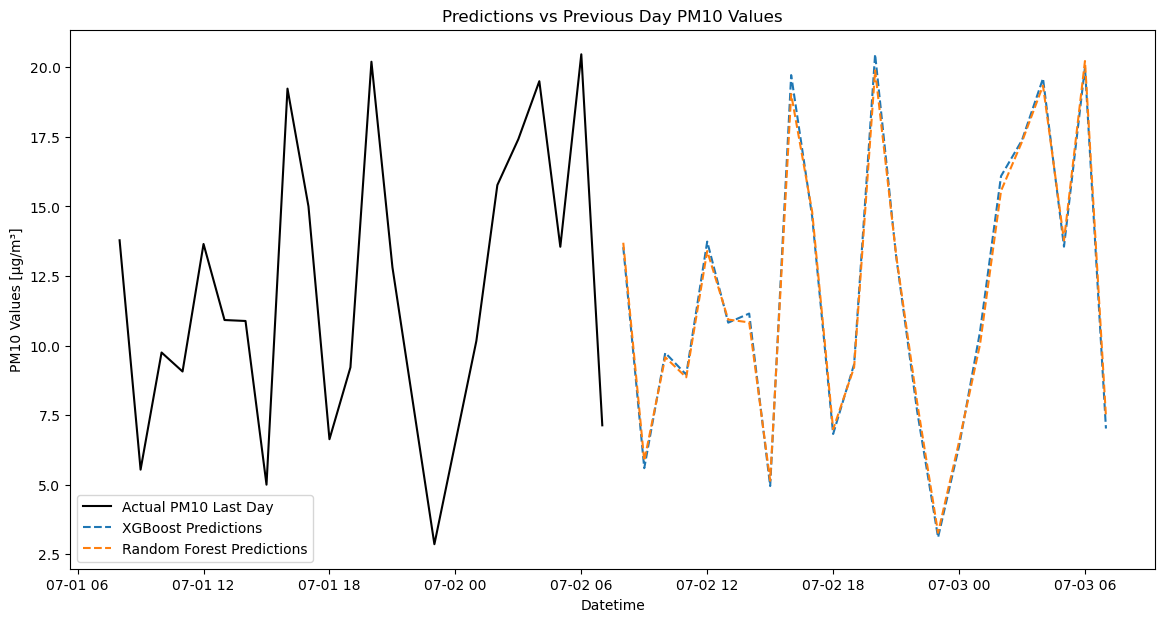

In [8]:
def visualize_predictions(last_day_pm10, pred_df):
    plt.figure(figsize=(14, 7))
    
    plt.plot(last_day_dates, last_day_pm10, label="Actual PM10 Last Day", color='black')
    plt.plot(pred_df.index, pred_df['xgb'], label="XGBoost Predictions", linestyle='--')
    plt.plot(pred_df.index, pred_df['rf'], label="Random Forest Predictions", linestyle='--')
    
    plt.xlabel("Datetime")
    plt.ylabel("PM10 Values [µg/m³]")
    plt.title("Predictions vs Previous Day PM10 Values")
    plt.legend()
    plt.show()

visualize_predictions(last_day_pm10, pred_df)
